# FastFashOff - Détection de logos de fast fashion

Application de recherche d'image par contenu pour détecter les logos de marques de fast fashion et sensibiliser aux impacts sociaux et environnementaux.

**Projet réalisé dans le cadre de l'UE 35LIAC04 - Informatique graphique et vision**  
Université Lyon 2 - L3 Informatique

## 1. Imports et configuration

In [12]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time

# Imports des modules FastFashOff
from config import LOGOS, IMAGES, LOGO_DIR, IMAGE_DIR, MIN_MATCHES, SEUIL_DISTANCE
from data_marques import MARQUES_INFO, LOGO_TO_MARQUE
from image_processing import load_image, filter_image, resize_image
from logo_detection import (
    extraire_features_orb,
    matcher_logos_avec_ratio,
    filtrer_bons_matches,
    valider_detection,
    dessiner_matches
)
from display import afficher_info_boycott, afficher_image_opencv, afficher_resume
from utils import (
    valider_structure_projet,
    afficher_statistiques_detection,
    generer_rapport_markdown
)

print("Modules chargés")
print(f"Configuration : MIN_MATCHES={MIN_MATCHES}, SEUIL_DISTANCE={SEUIL_DISTANCE}")


Modules chargés
Configuration : MIN_MATCHES=10, SEUIL_DISTANCE=50


## 2. Validation de la structure du projet


In [13]:
valide, message = valider_structure_projet()
print(f"{message}")

if valide:
    print(f"\nLogos disponibles : {len(LOGOS)}")
    for logo in LOGOS:
        print(f"   - {logo}")
    
    print(f"\nImages disponibles : {len(IMAGES)}")
    for img in IMAGES:
        print(f"   - {img}")

Logo introuvable : C:\ProjetL3\FastFashOff\data\logo\zara_logo.jpg


## 3. Visualisation des données


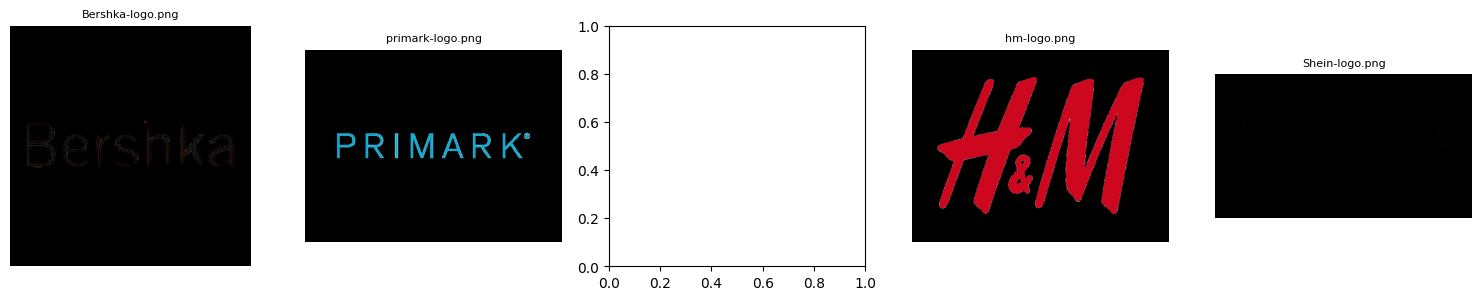

In [11]:
def afficher_logos_notebook():
    #Affiche tous les logos dans le notebook avec matplotlib
    fig, axes = plt.subplots(1, len(LOGOS), figsize=(15, 3))
    
    for i, logo_name in enumerate(LOGOS):
        logo_path = LOGO_DIR / logo_name
        img = load_image(logo_path, grayscale=False)
        
        if img is not None:
            # OpenCV charge en BGR, convertir en RGB pour matplotlib
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].set_title(logo_name, fontsize=8)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

afficher_logos_notebook()

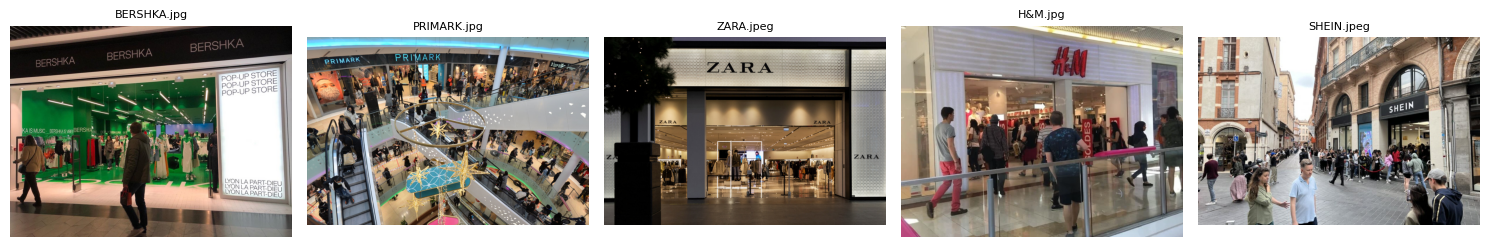

In [9]:
def afficher_images_notebook():
    #Affiche toutes les images du dataset dans le notebook.
    fig, axes = plt.subplots(1, len(IMAGES), figsize=(15, 3))
    
    for i, img_name in enumerate(IMAGES):
        img_path = IMAGE_DIR / img_name
        img = load_image(img_path, grayscale=False)
        
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i].imshow(img_rgb)
            axes[i].set_title(img_name, fontsize=8)
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

afficher_images_notebook()


## 4. Test du filtre sur une image

In [ ]:
# Charger une image de test
test_img_path = LOGO_DIR / LOGOS[0]
img_original = load_image(test_img_path, grayscale=True)
img_filtree = filter_image(img_original)

# Affichage côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(img_original, cmap='gray')
axes[0].set_title('Image originale (niveaux de gris)')
axes[0].axis('off')

axes[1].imshow(img_filtree, cmap='gray')
axes[1].set_title('Image après filtre (Canny + dilatation)')
axes[1].axis('off')

plt.tight_layout()
plt.show()


## 5. Test de détection ORB sur une paire logo/image

In [ ]:
def tester_detection_simple(index=0):
    """Teste la détection sur une paire logo/image spécifique."""
    logo_path = LOGO_DIR / LOGOS[index]
    img_path = IMAGE_DIR / IMAGES[index]
    
    print(f"Test : {LOGOS[index]} vs {IMAGES[index]}\n")
    
    # Chargement
    imgLogo = load_image(logo_path, grayscale=True)
    img = load_image(img_path, grayscale=True)
    
    if imgLogo is None or img is None:
        print("❌ Erreur de chargement")
        return
    
    # Filtrage
    imgLogo_filtered = filter_image(imgLogo)
    img_filtered = filter_image(img)
    
    # Extraction ORB
    kp0, des0 = extraire_features_orb(imgLogo_filtered)
    kp1, des1 = extraire_features_orb(img_filtered)
    
    print(f"Keypoints logo : {len(kp0)}")
    print(f"Keypoints image : {len(kp1)}")
    
    if des0 is None or des1 is None:
        print("❌ Pas de descripteurs")
        return
    
    # Matching
    matches = matcher_logos(des0, des1)
    good_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
    
    print(f"\nMatches totaux : {len(matches)}")
    print(f"Bons matches (dist<{SEUIL_DISTANCE}) : {len(good_matches)}")
    
    if matches:
        print(f"Distance min : {matches[0].distance:.1f}")
        print(f"Distance max : {matches[-1].distance:.1f}")
    
    # Validation
    valide = valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE)
    print(f"\n{'✓ Détection VALIDE' if valide else '✗ Détection INVALIDE'}")
    
    # Affichage visuel dans le notebook
    img_matches = dessiner_matches(imgLogo_filtered, kp0, img_filtered, kp1, matches, 25)
    img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(15, 5))
    plt.imshow(img_matches_rgb)
    plt.title(f"Matching : {LOGOS[index]} vs {IMAGES[index]} ({len(good_matches)} bons matches)")
    plt.axis('off')
    plt.show()

# Tester sur la première paire (index 0 = Bershka)
tester_detection_simple(0)


TEST: Sans filtre

✓ Bershka-logo.png vs BERSHKA.jpg
   Keypoints: logo=388, image=500
   Matches totaux: 101
   Bons matches (dist<50): 0
   Distance min/max: 53.0 / 89.0

✓ primark-logo.png vs PRIMARK.jpg
   Keypoints: logo=421, image=500
   Matches totaux: 75
   Bons matches (dist<50): 17
   Distance min/max: 23.0 / 78.0

✓ zara_logo.jpg vs ZARA.jpeg
   Keypoints: logo=493, image=500
   Matches totaux: 67
   Bons matches (dist<50): 18
   Distance min/max: 38.0 / 80.0

✓ hm-logo.png vs H&M.jpg
   Keypoints: logo=450, image=500
   Matches totaux: 50
   Bons matches (dist<50): 2
   Distance min/max: 44.0 / 85.0

✓ Shein-logo.png vs SHEIN.jpeg
   Keypoints: logo=129, image=500
   Matches totaux: 35
   Bons matches (dist<50): 1
   Distance min/max: 49.0 / 76.0


RÉSUMÉ - Sans filtre
Total matches: 328
Total bons matches (dist<50): 38
Ratio bons matches: 11.6%


TEST: Léger flou (3x3)

✓ Bershka-logo.png vs BERSHKA.jpg
   Keypoints: logo=386, image=500
   Matches totaux: 95
   Bons match

In [ ]:
# Tester toutes les autres paires
for i in range(1, len(LOGOS)):
    tester_detection_simple(i)

C:\ProjetL3\FastFashOff\data\logo\Bershka-logo.png False
C:\ProjetL3\FastFashOff\data\dataset\BERSHKA.jpg False
C:\ProjetL3\FastFashOff\data\logo\primark-logo.png False
C:\ProjetL3\FastFashOff\data\dataset\PRIMARK.jpg False
C:\ProjetL3\FastFashOff\data\logo\zara_logo.jpg False
C:\ProjetL3\FastFashOff\data\dataset\ZARA.jpeg False
C:\ProjetL3\FastFashOff\data\logo\hm-logo.png False
C:\ProjetL3\FastFashOff\data\dataset\H&M.jpg False
C:\ProjetL3\FastFashOff\data\logo\Shein-logo.png False
C:\ProjetL3\FastFashOff\data\dataset\SHEIN.jpeg False


## 6. Analyse complète du dataset

In [ ]:
def analyser_dataset_notebook():
    """Analyse complète avec affichage dans le notebook."""
    print("\n" + "🔍 FASTFASHOFF - Analyse en cours...".center(70))
    print("="*70 + "\n")
    
    debut = time.time()
    marques_detectees = []
    
    for i in range(len(IMAGES)):
        logo_path = LOGO_DIR / LOGOS[i]
        img_path = IMAGE_DIR / IMAGES[i]

        # Chargement
        imgLogo = load_image(logo_path, grayscale=True)
        img = load_image(img_path, grayscale=True)

        if imgLogo is None or img is None:
            print(f"⚠️  Impossible de lire : {LOGOS[i]} ou {IMAGES[i]}")
            continue

        # Filtrage
        imgLogo_filtered = filter_image(imgLogo)
        img_filtered = filter_image(img)

        # Extraction ORB
        kp0, des0 = extraire_features_orb(imgLogo_filtered)
        kp1, des1 = extraire_features_orb(img_filtered)

        if des0 is None or des1 is None:
            print(f"⚠️  Pas de descripteurs pour : {LOGOS[i]} ou {IMAGES[i]}")
            continue

        # Matching
        matches = matcher_logos(des0, des1)
        good_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
        
        # Validation
        if valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE):
            detection = {
                "logo": LOGOS[i],
                "image": IMAGES[i],
                "matches": len(good_matches),
                "distance_min": matches[0].distance if matches else 0
            }
            marques_detectees.append(detection)
            
            print(f"✓ Logo détecté: {LOGOS[i]}")
            print(f"  → Bons matches: {len(good_matches)}")
            print(f"  → Distance minimale: {matches[0].distance:.1f}\n")
            
            # Affichage visuel
            img_matches = dessiner_matches(imgLogo_filtered, kp0, img_filtered, kp1, matches, 25)
            img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
            
            plt.figure(figsize=(15, 5))
            plt.imshow(img_matches_rgb)
            plt.title(f"{LOGOS[i]} vs {IMAGES[i]} - {len(good_matches)} matches")
            plt.axis('off')
            plt.show()
            
            # Affichage info boycott
            afficher_info_boycott(LOGOS[i])
        else:
            print(f"✗ Pas de détection : {LOGOS[i]} vs {IMAGES[i]}")
            print(f"  → Matches: {len(good_matches)} (minimum: {MIN_MATCHES})\n")
    
    # Résumé
    temps_ecoule = time.time() - debut
    afficher_resume(marques_detectees)
    afficher_statistiques_detection(marques_detectees)
    print(f"\n⏱️  Temps d'exécution : {temps_ecoule:.2f}s\n")
    
    return marques_detectees

# Lancer l'analyse
resultats = analyser_dataset_notebook()


## 7. Analyse d'une image spécifique

In [ ]:
def analyser_image_notebook(nom_image):
    """Analyse une image spécifique et cherche tous les logos."""
    img_path = IMAGE_DIR / nom_image
    img = load_image(img_path, grayscale=True)
    
    if img is None:
        print(f"❌ Impossible de lire l'image: {nom_image}")
        return
    
    print(f"\n🔍 Analyse de: {nom_image}\n")
    img_filtered = filter_image(img)
    
    marques_trouvees = []
    
    for logo_name in LOGOS:
        logo_path = LOGO_DIR / logo_name
        imgLogo = load_image(logo_path, grayscale=True)
        
        if imgLogo is None:
            continue
        
        imgLogo_filtered = filter_image(imgLogo)
        
        kp0, des0 = extraire_features_orb(imgLogo_filtered)
        kp1, des1 = extraire_features_orb(img_filtered)
        
        if des0 is None or des1 is None:
            continue
        
        matches = matcher_logos(des0, des1)
        good_matches = filtrer_bons_matches(matches, SEUIL_DISTANCE)
        
        if valider_detection(matches, MIN_MATCHES, SEUIL_DISTANCE):
            marques_trouvees.append({
                "logo": logo_name,
                "matches": len(good_matches),
                "distance_min": matches[0].distance
            })
            print(f"✓ {logo_name} détecté ({len(good_matches)} matches)")
            
            # Affichage visuel
            img_matches = dessiner_matches(imgLogo_filtered, kp0, img_filtered, kp1, matches, 25)
            img_matches_rgb = cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB)
            
            plt.figure(figsize=(15, 5))
            plt.imshow(img_matches_rgb)
            plt.title(f"{logo_name} détecté - {len(good_matches)} matches")
            plt.axis('off')
            plt.show()
    
    if marques_trouvees:
        print(f"\n🚨 {len(marques_trouvees)} marque(s) trouvée(s):\n")
        for detection in marques_trouvees:
            afficher_info_boycott(detection['logo'])
    else:
        print("\n✅ Aucune marque de fast fashion détectée!")
    
    return marques_trouvees

# Exemple : analyser l'image ZARA
analyser_image_notebook("ZARA.jpeg")

## 8. Génération d'un rapport Markdown

In [1]:
# Générer un rapport Markdown des détections
if resultats:
    generer_rapport_markdown(resultats, "rapport_fastfashoff.md")
    print("Rapport généré : rapport_fastfashoff.md")
else:
    print("Aucune détection à inclure dans le rapport")

NameError: name 'resultats' is not defined

## 9. Tests et expérimentations

In [ ]:
def comparer_seuils():
    #Compare différents seuils de détection
    seuils_distance = [30, 40, 50, 60]
    seuils_min_matches = [10, 15, 20, 25]
    
    print("\n" + "="*70)
    print("COMPARAISON DE SEUILS".center(70))
    print("="*70 + "\n")
    
    resultats_comparaison = []
    
    for seuil_dist in seuils_distance:
        for min_match in seuils_min_matches:
            print(f"\nTest : SEUIL_DISTANCE={seuil_dist}, MIN_MATCHES={min_match}")
            print("-" * 50)
            
            detections = 0
            total_matches = 0
            
            for i in range(len(IMAGES)):
                logo_path = LOGO_DIR / LOGOS[i]
                img_path = IMAGE_DIR / IMAGES[i]
                
                imgLogo = load_image(logo_path, grayscale=True)
                img = load_image(img_path, grayscale=True)
                
                if imgLogo is None or img is None:
                    continue
                
                imgLogo_filtered = filter_image(imgLogo)
                img_filtered = filter_image(img)
                
                kp0, des0 = extraire_features_orb(imgLogo_filtered)
                kp1, des1 = extraire_features_orb(img_filtered)
                
                if des0 is None or des1 is None:
                    continue
                
                matches = matcher_logos(des0, des1)
                good_matches = filtrer_bons_matches(matches, seuil_dist)
                
                if valider_detection(matches, min_match, seuil_dist):
                    detections += 1
                    total_matches += len(good_matches)
            
            print(f"Détections : {detections}/{len(IMAGES)}")
            print(f"Total bons matches : {total_matches}")
            
            resultats_comparaison.append({
                "seuil_distance": seuil_dist,
                "min_matches": min_match,
                "detections": detections,
                "total_matches": total_matches
            })
    
    # Affichage tableau récapitulatif
    print("\n" + "="*70)
    print("TABLEAU RÉCAPITULATIF".center(70))
    print("="*70)
    print(f"{'Seuil Dist':<15} {'Min Matches':<15} {'Détections':<15} {'Total Matches':<15}")
    print("-" * 70)
    
    for res in resultats_comparaison:
        print(f"{res['seuil_distance']:<15} {res['min_matches']:<15} "
              f"{res['detections']:<15} {res['total_matches']:<15}")
    
    return resultats_comparaison

# Lancer la comparaison
resultats_seuils = comparer_seuils()


## 10. Informations sur les marques

In [ ]:
def afficher_toutes_marques():
    #Affiche les informations de toutes les marques
    print("\n" + "="*70)
    print("BASE DE DONNÉES DES MARQUES".center(70))
    print("="*70 + "\n")
    
    for marque_key, info in MARQUES_INFO.items():
        print(f"\n  {info['nom_complet']}")
        print("-" * 70)
        print(f"\n {info['faits']}")
        print(f"\n Raisons principales :")
        for i, raison in enumerate(info['raisons'][:3], 1):  # Top 3
            print(f"   {i}. {raison}")
        print(f"\n Alternatives : {info['alternatives']}")
        print("\n" + "="*70)

afficher_toutes_marques()


## 11. Conclusion et perspectives


## 12. Ressources et références

### Documentation utilisée
- [OpenCV Documentation](https://docs.opencv.org/)
- [ORB Feature Detection](https://docs.opencv.org/4.x/d1/d89/tutorial_py_orb.html)
- [Feature Matching](https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html)

### Sources sur la fast fashion
- Clean Clothes Campaign : https://cleanclothes.org/
- Fashion Revolution : https://www.fashionrevolution.org/
- Documentaire "The True Cost" (2015)
- Rapport Changing Markets Foundation

### Marques éthiques alternatives
- Good On You : https://goodonyou.eco/
- Clear Fashion : https://clearfashion.com/
- Slow Fashion Movement

In [ ]:
# Nettoyage final
print("\n✓ Notebook terminé")
print("Pour relancer l'analyse complète : analyser_dataset_notebook()")
print("Pour analyser une image : analyser_image_notebook('nom_fichier.jpg')")
print("Pour générer un rapport : generer_rapport_markdown(resultats)")
